<a href="https://colab.research.google.com/github/dressyflame/UAI-Homework/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%98%D0%BD%D1%82%D0%B5%D0%B3%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%BD%D0%B0_%D0%94%D0%95%D0%9C%D0%9E_%D0%9F%D0%90%D0%9D%D0%95%D0%9B%D0%AC_%7C_%D0%94%D0%97_Pro_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Необходимо создать, обучить нейронную сеть с точностью не менее 85% и упаковать её в архив для загрузки на демо-панель:
* создать нейронную сеть для распознавания марки автомобиля из 3х вариантов
* сохраните веса
* подготовить запуск модели "из коробки"
* подготовить архив с готовой нейронной сетью для загрузки в демо-панель


In [1]:
# Сеть прямого распространения
from tensorflow.keras.models import Sequential 

# Базовые слои для свёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Работа с изображениями
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Оптимизаторы
from tensorflow.keras.optimizers import Adam     

# Используем для to_categoricall
from tensorflow.keras import utils               

# Для отрисовки изображений
from tensorflow.keras.preprocessing import image 

# Библиотека работы с массивами
import numpy as np

# Для отрисовки графиков
import matplotlib.pyplot as plt                  

# Для отрисовки изображений
from PIL import Image                            

# Для генерации случайных чисел 
import random                                    

# Для округления
import math                                      

# Для работы с файлами 
import os                                        

## Распознавание марок машин

In [2]:
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l6/car_test.zip', None, quiet=True) 

'car_test.zip'

In [7]:
!unzip -q middle_fmr.zip -d /content/cars # Указываем путь к базе в Google Drive

In [8]:
classes = os.listdir('cars')
print(classes)

['Mercedes', 'Ferrari', 'Renault']


In [9]:
train_path = '/content/cars' # Папка с папками картинок, рассортированных по категориям
batch_size = 10  # Размер выборки
img_width = 288  # Ширина изображения
img_height = 162 # Высота изображения

In [10]:
# Генератор изображений

datagen = ImageDataGenerator(
    rescale=1. / 255,       # Значения цвета меняем на дробные показания
    rotation_range=10,      # Поворачиваем изображения при генерации выборки
    width_shift_range=0.1,  # Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, # Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1,         # Зумируем изображения при генерации выборки
    horizontal_flip=True,   # Отключаем отзеркаливание изображений
    fill_mode='nearest',    # Заполнение пикселей вне границ ввода
    validation_split=0.2    # Указываем разделение изображений на обучающую и тестовую выборку
)

In [29]:
# Обучающая выборка

train_generator = datagen.flow_from_directory(
    train_path,                          # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True,                        # Перемешивание выборки
    subset='training'                    # устанавливаем как набор для обучения
)

# Проверочная выборка

validation_generator = datagen.flow_from_directory(
    train_path,                          # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=True,                        # Перемешивание выборки
    subset='validation'                  # Устанавливаем как валидационный набор
)

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


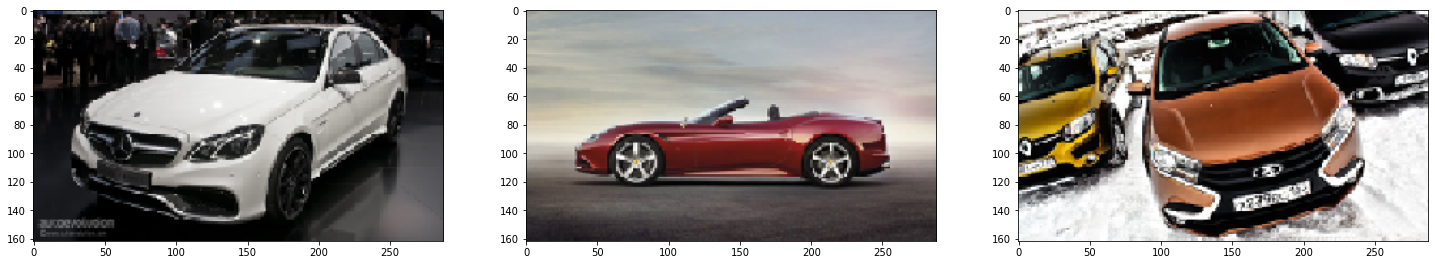

In [30]:
# Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 3, figsize=(25, 5)) # Создаем полотно из 3 графиков

for i in range(3):                             # Проходим по всем классам
  car_path = train_path + '/' + os.listdir(train_path)[i] + '/' # Формируем путь к выборке
  img_path = car_path + random.choice(os.listdir(car_path))     # Выбираем случайное фото для отображения
  axs[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) # Отображение фотографии

plt.show() # Выводим изображения

In [31]:
# Создаем последовательную модель

model = Sequential()

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3))) # Сверточный слой
model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(Dropout(0.3)) # Слой регуляризации Dropout
model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.3)) # Слой регуляризации Dropout

model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) # Сверточный слой
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu')) ## Сверточный слой
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.3)) # Слой регуляризации Dropout

model.add(Flatten()) # Слой преобразования двумерных данных в одномерные 

model.add(Dense(2048, activation='elu')) # Полносвязный слой
model.add(Dense(4096, activation='elu')) # Полносвязный слой

model.add(Dense(len(train_generator.class_indices), activation='softmax')) # Вызодной полносвязный слой

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=60,
    verbose=1
)

Epoch 1/60
274/274 [==============================] - 143s 465ms/step - loss: 1.0198 - accuracy: 0.4643 - val_loss: 0.9887 - val_accuracy: 0.4868
Epoch 2/60
274/274 [==============================] - 127s 461ms/step - loss: 0.9231 - accuracy: 0.5617 - val_loss: 0.9630 - val_accuracy: 0.5471
Epoch 3/60
274/274 [==============================] - 127s 461ms/step - loss: 0.8792 - accuracy: 0.5847 - val_loss: 0.9607 - val_accuracy: 0.5397
Epoch 4/60
274/274 [==============================] - 126s 461ms/step - loss: 0.8315 - accuracy: 0.6074 - val_loss: 0.8809 - val_accuracy: 0.5882
Epoch 5/60
274/274 [==============================] - 127s 461ms/step - loss: 0.7997 - accuracy: 0.6370 - val_loss: 0.8757 - val_accuracy: 0.6059
Epoch 6/60
274/274 [==============================] - 126s 461ms/step - loss: 0.7791 - accuracy: 0.6579 - val_loss: 0.8406 - val_accuracy: 0.6118
Epoch 7/60
274/274 [==============================] - 127s 461ms/step - loss: 0.7368 - accuracy: 0.6769 - val_loss: 0.8579 -

In [11]:
# Дообучаем модель ещё на 50 эпохах с уменьшенным шагом
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=50,
    verbose=1
)

In [ ]:
# Дообучаем модель ещё на 20 эпохах с уменьшенным шагом
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=20,
    verbose=1
)

In [ ]:
model.summary()

In [ ]:
# Отображаем график точности обучения

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

def predict(img_path = './test_image_1.jpg', model_path = './model.h5'):
    classes = {
        0: 'Mercedes', 
        1: 'Ferrari', 
        2: 'Renault'
    }

    model.load_model(model_path)

    img_width = 288  # Ширина изображения
    img_height = 162 # Высота изображения

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float32')
    display(img)
    image = image / 255
    image = np.expand_dims(image, axis=0)
    image.reshape(image.shape[0], img_height, img_width, 1)

    cls_image = np.argmax(model.predict(image))

    print(classes[csl_image])


In [3]:
!unzip -qo car_test.zip

In [28]:
text_code = '''

from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

def predict(img_path = './test_image_1.jpg', model_path = './model.h5'):
    classes = {
        0: 'Mercedes', 
        1: 'Ferrari', 
        2: 'Renault'
    }

    model.load_model(model_path)

    img_width = 288  # Ширина изображения
    img_height = 162 # Высота изображения

    img = Image.open(img_path).resize((img_height, img_width))
    image = np.array(img, dtype='float32') / 255

    image = np.expand_dims(image, axis=0)
    image.reshape(image.shape[0], img_height, img_width, 1)

    cls_image = np.argmax(model.predict(image))

    print(classes[csl_image])

'''

with open('script.py', 'w') as f:
    f.write(text_code.strip())

In [5]:
text_labels = '''

'Mercedes'
'Ferrari'
'Renault'

'''

with open('label.txt', 'w') as f:
    f.write(text_labels.strip())

In [6]:
from shutil import copyfile

for i in range(10):
    copyfile(f'./car_test/{i}.jpg', f'./{i}.jpg')

In [ ]:
from zipfile import ZipFile as Zip

# Список всех файлов
integrate_files = ['model.h5', 'script.py', 'label.txt', *[f'{i}.jpg' for i in range(10)]]

zipArchive = Zip('/content/archive.zip', 'w')  # Открытие файла, если такого не существует - будет создан новый

for file in integrate_files:                   # Для всех всем нужных файлов:
    if os.path.exists(file):                   # Если файл существует,
        zipArchive.write(file)                 # то добавление его в архив
    else:
        print(f'Файл {file} отсутствует!')     # иначе вывод на экран названия отсутствующего файла

zipArchive.close()                             # В финале архив следует закрыть, как и обычный файл

In [ ]:
from google.colab import files               # Функция для скачивания данных на локальный компьютер

files.download(filename='archive.zip')       # Скачивание готового архива

print('Архив загружен')